In [81]:
import numpy as np
import pandas as pd 
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.image import imread
from PIL import Image
import matplotlib.patheffects as path_effects


In [2]:
ff1.Cache.enable_cache('../cache')

In [3]:
year, event, event_type = 2023, 'Azerbaijan', 'Q'
session = ff1.get_session(year, event, event_type)
laps = session.load_laps(with_telemetry=True)

C:\Users\getou\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v2.3.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
C:\Users\getou\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=

In [28]:
driver_1, driver_2 = 'LEC', 'VER'
distance_min, distance_max = 2900, 4000

In [29]:
laps_driver_1 = laps.pick_driver(driver_1)
laps_driver_2 = laps.pick_driver(driver_2)
#lap_12 = laps_driver_1.loc[laps_driver_1['LapNumber'] == 12]
#idk_mate = laps_driver_1.loc[laps_driver_1['LapNumber'] == 13]

telemetry_driver_1 = laps_driver_1.pick_fastest().get_car_data().add_distance()
telemetry_driver_2 = laps_driver_2.pick_fastest().get_car_data().add_distance()

team_driver_1 = laps_driver_1.reset_index().loc[0, 'Team']
team_driver_2 = laps_driver_2.reset_index().loc[0, 'Team']

In [30]:
telemetry_driver_1.loc[telemetry_driver_1['Brake'] > 0, 'CurrentAction'] = 'Brake'
telemetry_driver_1.loc[telemetry_driver_1['Throttle'] == 100, 'CurrentAction'] = 'Full Throttle'
telemetry_driver_1.loc[(telemetry_driver_1['Brake'] == 0) & (telemetry_driver_1['Throttle'] < 100), 'CurrentAction'] = 'Cornering'

telemetry_driver_2.loc[telemetry_driver_2['Brake'] > 0, 'CurrentAction'] = 'Brake'
telemetry_driver_2.loc[telemetry_driver_2['Throttle'] == 100, 'CurrentAction'] = 'Full Throttle'
telemetry_driver_2.loc[(telemetry_driver_2['Brake'] == 0) & (telemetry_driver_2['Throttle'] < 100), 'CurrentAction'] = 'Cornering'

In [31]:
telemetry_driver_1['ActionID'] = (telemetry_driver_1['CurrentAction'] != telemetry_driver_1['CurrentAction'].shift(1)).cumsum()
telemetry_driver_2['ActionID'] = (telemetry_driver_2['CurrentAction'] != telemetry_driver_2['CurrentAction'].shift(1)).cumsum()

In [32]:
actions_driver_1 = telemetry_driver_1[['ActionID', 'CurrentAction', 'Distance']].groupby(['ActionID', 'CurrentAction']).max('Distance').reset_index()
actions_driver_2 = telemetry_driver_2[['ActionID', 'CurrentAction', 'Distance']].groupby(['ActionID', 'CurrentAction']).max('Distance').reset_index()

actions_driver_1['Driver'] = driver_1
actions_driver_2['Driver'] = driver_2

In [33]:
actions_driver_1['DistanceDelta'] = actions_driver_1['Distance'] - actions_driver_1['Distance'].shift(1)
actions_driver_1.loc[0, 'DistanceDelta'] = actions_driver_1.loc[0, 'Distance']

actions_driver_2['DistanceDelta'] = actions_driver_2['Distance'] - actions_driver_2['Distance'].shift(1)
actions_driver_2.loc[0, 'DistanceDelta'] = actions_driver_2.loc[0, 'Distance']

In [34]:
all_actions = actions_driver_1.append(actions_driver_2)

C:\Users\getou\AppData\Local\Temp\ipykernel_28552\3193369198.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_actions = actions_driver_1.append(actions_driver_2)


In [35]:
avg_speed_driver_1 = np.mean(telemetry_driver_1['Speed'].loc[
    (telemetry_driver_1['Distance'] >= distance_min) & 
        (telemetry_driver_1['Distance'] <= distance_max) 
])


avg_speed_driver_2 = np.mean(telemetry_driver_2['Speed'].loc[
    (telemetry_driver_2['Distance'] >= distance_min) & 
        (telemetry_driver_2['Distance'] <= distance_max) 
])

if avg_speed_driver_1 > avg_speed_driver_2:    
    speed_text = f"{driver_1} {round(avg_speed_driver_1 - avg_speed_driver_2,2)}km/h faster"
else:
    speed_text = f"{driver_2} {round(avg_speed_driver_2 - avg_speed_driver_1,2)}km/h faster"


In [36]:
# Add a column for TimeDelta to the telemetry data
telemetry_driver_1['TimeDelta'] = telemetry_driver_1['Time'].diff().fillna(pd.Timedelta(seconds=0))
telemetry_driver_2['TimeDelta'] = telemetry_driver_2['Time'].diff().fillna(pd.Timedelta(seconds=0))

# Calculate total time of the telemetry data for each driver (convert to seconds)
total_time_driver_1 = telemetry_driver_1.iloc[-1]['Time'].total_seconds()
total_time_driver_2 = telemetry_driver_2.iloc[-1]['Time'].total_seconds()

# Calculate total time spent at full throttle for each driver (convert TimeDelta to seconds)
full_throttle_time_driver_1 = telemetry_driver_1.loc[telemetry_driver_1['CurrentAction'] == 'Full Throttle', 'TimeDelta'].sum().total_seconds()
full_throttle_time_driver_2 = telemetry_driver_2.loc[telemetry_driver_2['CurrentAction'] == 'Full Throttle', 'TimeDelta'].sum().total_seconds()

# Calculate the percentage of time spent at full throttle for each driver
full_throttle_percentage_driver_1 = (full_throttle_time_driver_1 / total_time_driver_1) * 100
full_throttle_percentage_driver_2 = (full_throttle_time_driver_2 / total_time_driver_2) * 100

In [37]:
plot_width = 13
plot_height = 4
plot_size = [plot_width, plot_height]
title_font_size = int(2 * plot_height)  # Adjust the 0.15 multiplier to your liking
axis_label_font_size = int(1.5 * plot_height)  # Adjust the 0.1 multiplier to your liking
autolayout = True
plot_title = f"{driver_1} Time Spent at Full Throttle: {full_throttle_percentage_driver_1: .2f}% \n {driver_2} Time Spent at Full Throttle: {full_throttle_percentage_driver_2: .2f}%"
plot_file = f"{session.event.year} {session.event.EventName}-{driver_1} VS {driver_2}-CornerAnalasys"
plot_ratios = [7,7]
plot_filename = plot_file.replace(" ", "") + ".png"
logo_path = '../RCKMG_logo.png'
logo_img = Image.open(logo_path)

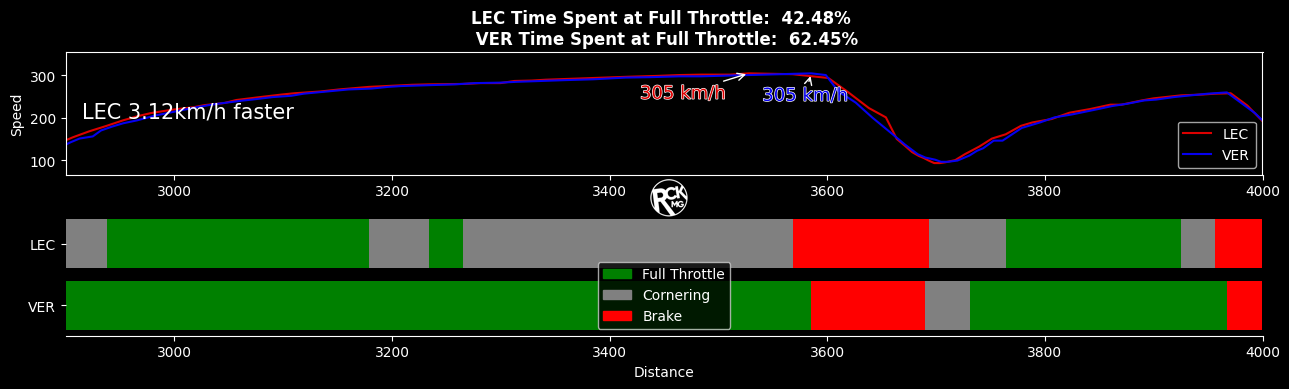

In [98]:
plt.rcParams['figure.figsize'] = plot_size
plt.rcParams['figure.autolayout'] = autolayout

telemetry_colors = {
    'Full Throttle': 'green',
    'Cornering': 'grey',
    'Brake': 'red',
}

fig, ax = plt.subplots(2)
# Filter data by the distance thresholds
filtered_telemetry_driver_1 = telemetry_driver_1[(telemetry_driver_1['Distance'] >= distance_min) & (telemetry_driver_1['Distance'] <= distance_max)]
filtered_telemetry_driver_2 = telemetry_driver_2[(telemetry_driver_2['Distance'] >= distance_min) & (telemetry_driver_2['Distance'] <= distance_max)]

# Find the index of maximum speed for each driver within the thresholds
max_speed_index_driver_1 = filtered_telemetry_driver_1['Speed'].idxmax()
max_speed_index_driver_2 = filtered_telemetry_driver_2['Speed'].idxmax()

# Find the maximum speed for each driver within the thresholds
max_speed_driver_1 = telemetry_driver_1.loc[max_speed_index_driver_1, 'Speed']
max_speed_driver_2 = telemetry_driver_2.loc[max_speed_index_driver_2, 'Speed']

# Find the distance at the maximum speed for each driver within the thresholds
max_speed_distance_driver_1 = telemetry_driver_1.loc[max_speed_index_driver_1, 'Distance']
max_speed_distance_driver_2 = telemetry_driver_2.loc[max_speed_index_driver_2, 'Distance']

# Annotate the maximum speed for driver 1 within the thresholds
text_driver_1 = ax[0].annotate(f'{max_speed_driver_1} km/h',
               xy=(max_speed_distance_driver_1, max_speed_driver_1),
               xytext=(max_speed_distance_driver_1 - 100, max_speed_driver_1 - 60),
               arrowprops=dict(facecolor='black', arrowstyle='->'),
               fontsize=13, color=ff1.plotting.team_color(team_driver_1))
text_driver_1.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()])

# Annotate the maximum speed for driver 2 within the thresholds
text_driver_2 = ax[0].annotate(f'{max_speed_driver_2} km/h',
               xy=(max_speed_distance_driver_2, max_speed_driver_2),
               xytext=(max_speed_distance_driver_2 - 45, max_speed_driver_2 - 65),
               arrowprops=dict(facecolor='black', arrowstyle='->'),
               fontsize=13, color=ff1.plotting.team_color(team_driver_2))
text_driver_2.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()])


ax[0].set_title(plot_title, fontweight='bold')
ax[0].plot(telemetry_driver_1['Distance'], telemetry_driver_1['Speed'], label=driver_1, color=ff1.plotting.team_color(team_driver_1))
ax[0].plot(telemetry_driver_2['Distance'], telemetry_driver_2['Speed'], label=driver_2, color=ff1.plotting.team_color(team_driver_2))

ax[0].text(distance_min+15, 200, speed_text, fontsize=15)

ax[0].set(ylabel='Speed')
ax[0].legend(loc='lower right')

for driver in [driver_1, driver_2]:
    driver_actions = all_actions.loc[all_actions['Driver'] == driver]
    
    previous_action_end = 0
    for _, action in driver_actions.iterrows():
        ax[1].barh(
            [driver],
            action['DistanceDelta'],
            left = previous_action_end,
            color = telemetry_colors[action['CurrentAction']]
        )
        
        previous_action_end = previous_action_end + action['DistanceDelta']
        
plt.xlabel('Distance')

plt.gca().invert_yaxis()

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)

labels = list(telemetry_colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=telemetry_colors[label]) for label in labels]
ax[1].legend(handles, labels)

ax[0].set_xlim(distance_min, distance_max)
ax[1].set_xlim(distance_min, distance_max)

# Define the new width and height for the logo
new_width = 38
new_height = 38
# Resize the logo
logo_resized = logo_img.resize((new_width, new_height))
logo_resized_np = np.array(logo_resized)
logo_x = 650
logo_y = 172
fig.figimage(logo_resized_np, xo=logo_x, yo=logo_y, zorder=1, origin='upper', alpha=1)

plt.style.use('dark_background')
plt.savefig(plot_filename, dpi=300)
plt.show()
# print(laps_driver_1.pick_fastest())
# print(laps_driver_2.pick_fastest())